![Cauldron-logo-JPG-01-800x123.jpg](Cauldron-logo-JPG-01-800x123.jpg)

# Calculate LCIA for Spent solvent

## Changelog

### 2 - (2023-11-17)

+ Compare all EF v3.0 impact categories


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext jupyter_black

In [3]:
import pandas as pd
from tqdm import tqdm
import copy

In [4]:
import bw2data as bd
import bw2calc as bc

In [5]:
bd.projects.set_current("ecoinvent-3.8-ei")

In [6]:
bd.databases

Databases dictionary with 2 object(s):
	ecoinvent-3.8-biosphere
	ecoinvent-3.8-cutoff

# Find the benchmark dataset
We will use `Market for spent solvent mixture` from `Europe without Switzerland` as the benchmark activity.

In [7]:
from bw2data.query import Query, Filter

In [8]:
q = Query()
name_filter = Filter("name", "is", "market for spent solvent mixture")
location_filter = Filter("location", "is", "Europe without Switzerland")
q.add(name_filter)
q.add(location_filter)

In [9]:
ei_data = bd.Database("ecoinvent-3.8-cutoff").load()

In [10]:
res = q(ei_data)
res

Query result: (total 1)
('ecoinvent-3.8-cutoff', 'f31dea514d74ebd48b7fdee4b81c80cd'): market for spent solvent mixture

In [11]:
spent_a_key = list(res.result.keys())[0]
spent_a = bd.get_activity(spent_a_key)
spent_a

'market for spent solvent mixture' (kilogram, Europe without Switzerland, None)

# Create new method without the CFs added by EI.
We will compare the total scores of the `'market for spent solvent mixture' (kilogram, Europe without Switzerland, None)` activity using 2 LCIA methods.

+ The original "**EF v3.0 material resources: metals/minerals abiotic depletion potential (ADP): elements (ultimate reserves)**" that is implemented by default in Brightway using the data published by Ecoinvent.
+ A copy of this same method, where we remove some characterization factors that were reported to have been added by Ecoinvent in their implementation.

## Extract the list of added CFs

Per the [Ecoinvent LCIA_implementation 3.9 3.9.1 report](https://ecoinvent.org/wp-content/uploads/2023/01/LCIA_implementation_3.9-and-3.9.1.pdf) page 35, CFs were added for the following substances

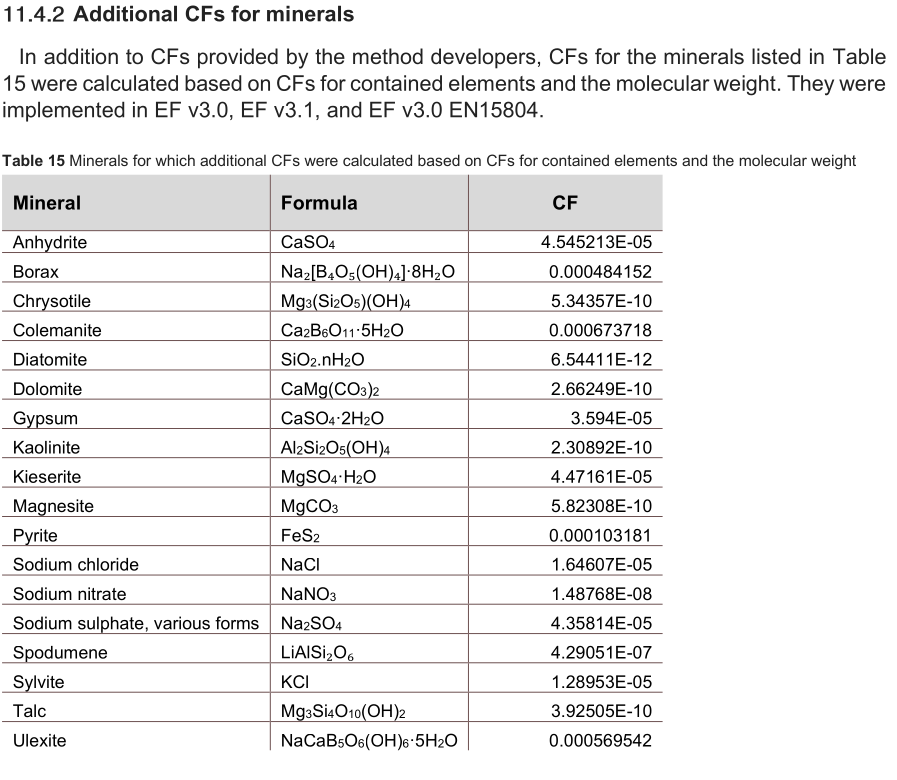

In [12]:
new_subs = [
    "Anhydrite",
    "Borax",
    "Chrysotile",
    "Colemanite",
    "Diatomite",
    "Dolomite",
    "Gypsum",
    "Kaolinite",
    "Kieserite",
    "Magnesite",
    "Pyrite",
    "Sodium chloride",
    "Sodium nitrate",
    "Sodium sulphate, various forms",
    "Spodumene",
    "Sylvite",
    "Talc",
    "Ulexite",
]
new_subs_d = {ei_name: None for ei_name in new_subs}

## Mineral resources metals

In [13]:
ef_mr_key = (
    "EF v3.0",
    "material resources: metals/minerals",
    "abiotic depletion potential (ADP): elements (ultimate reserves)",
)
ef_mr = bd.Method(ef_mr_key)

In [14]:
cfs_orig = ef_mr.load()

In [15]:
cfs_new = copy.deepcopy(cfs_orig)  #

In [16]:
bio_data = bd.Database("ecoinvent-3.8-biosphere").load()

In [17]:
for sub in new_subs_d.keys():
    q = Query()
    # EI provides only the raw name, but in bw we have ", in ground" suffix
    name_filter = Filter("name", "is", f"{sub}, in ground")
    q.add(name_filter)
    res = q(bio_data)
    if len(res) == 1:
        flow = list(res.result.keys())[0]
        new_subs_d.update({sub: bd.get_id(flow)})

In [18]:
# Make sure we have a key for each new substance name
assert all([v for _, v in new_subs_d.items()])
print(f"There are {len(new_subs_d)} _potential_ CFs to remove")

There are 18 _potential_ CFs to remove


In [19]:
print(f"Original number of CFs in method: {len(cfs_orig)}")

Original number of CFs in method: 149


In [20]:
orig_cfs_ids = [cf[0] for cf in cfs_orig]
for flow_id in new_subs_d.values():
    flow = bd.get_activity(flow_id)
    if flow_id in orig_cfs_ids:
        print(f"✅{flow} IS characterized in the method originally")
    else:
        print(f"🚫 {flow} NOT characterized in the method originally")

🚫 'Anhydrite, in ground' (kilogram, None, ('natural resource', 'in ground')) NOT characterized in the method originally
✅'Borax, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Chrysotile, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Colemanite, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Diatomite, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Dolomite, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Gypsum, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Kaolinite, in ground' (kilogram, None, ('natural resource', 'in ground')) IS characterized in the method originally
✅'Kieserite, in ground' (kilogram, None, ('natural resource'

In [21]:
cfs_new = [cf for cf in cfs_new if cf[0] not in new_subs_d.values()]

In [22]:
print(f"New number of CFs in method: {len(cfs_new)}")

New number of CFs in method: 132


## Create the new method

In [23]:
new_method_key = (
    "EF v3.0 - minus EI added cfs",
    "material resources: metals/minerals",
    "abiotic depletion potential (ADP): elements (ultimate reserves)",
)
new_method = bd.Method(new_method_key)
new_method.register()

In [24]:
[
    m
    for m in bd.methods
    if "EF v3.0" in m[0]
    and "EN15804" not in m[0]
    and "no LT" not in m[0]
    and "minerals" in m[1]
]

[('EF v3.0',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)'),
 ('EF v3.0 - minus EI added cfs',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)'),
 ('EF v3.0 - without EI added CFs',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)')]

In [25]:
new_method.write(cfs_new)

In [26]:
new_method.metadata["unit"] = ef_mr.metadata["unit"]

In [27]:
new_method_key = (
    "EF v3.0 - minus EI added cfs",
    "material resources: metals/minerals",
    "abiotic depletion potential (ADP): elements (ultimate reserves)",
)
new_method = bd.Method(new_method_key)

In [28]:
cfs_new_method = new_method.load()
print(f"There are {len(cfs_new_method)} cfs in the new method")

There are 132 cfs in the new method


## Do the LCIA

## Original method with EI added CFS

In [29]:
orig_lca = bc.LCA({spent_a: 1}, ef_mr_key)

In [30]:
orig_lca.lci()
orig_lca.lcia()
print(f"Original score: {orig_lca.score} {ef_mr.metadata['unit']}")

Original score: -1.4610609160523985e-06 kg Sb-Eq


## Using the modified method without the EI added CFS

In [31]:
new_lca = bc.LCA({spent_a: 1}, new_method_key)

In [32]:
new_lca.lci()
new_lca.lcia()
print(f"New score: {new_lca.score} {new_method.metadata['unit']}")

New score: -9.167217832077767e-07 kg Sb-Eq


# All impact categories

We now verify if any of the other method categories characterise the substances of the CFs added by Ecoinvent to the "EF v3.0" method.

In [33]:
old_ef_methods = [m for m in bd.methods if m[0] == "EF v3.0"]

The report from EI specifies that new characterization factors were added only for minerals. As can be seen below, only the _material resources: metals/minerals_ impact category has such additional cfs, hence results wouldn't change from what is already observed as a consequence of the **additional CFs added by Ecoinvent**.

In [34]:
records = []
for m in old_ef_methods:
    cfs_new = copy.copy(bd.Method(m).load())
    new_method_key = (f"{m[0]} - without EI added CFs", m[1], m[2])
    the_method = bd.Method(m)
    n_orig = len(cfs_new)
    cfs_new = [cf for cf in cfs_new if cf[0] not in new_subs_d.values()]
    sign = "✅"
    if n_orig != len(cfs_new):
        sign = "🫣"
    records.append(
        {
            "method": m[0],
            "category": m[1],
            "subcategory": m[2],
            "unit": the_method.metadata["unit"],
            "original_cfs": n_orig,
            "modified_cfs": len(cfs_new),
            "eval": sign,
        }
    )

res_df = pd.DataFrame(records)

In [35]:
res_df

,method,category,subcategory,unit,original_cfs,modified_cfs,eval
0,EF v3.0,acidification,accumulated exceedance (ae),mol H+-Eq,21,21,✅
1,EF v3.0,climate change,global warming potential (GWP100),kg CO2-Eq,202,202,✅
2,EF v3.0,climate change: biogenic,global warming potential (GWP100),kg CO2-Eq,5,5,✅
3,EF v3.0,climate change: fossil,global warming potential (GWP100),kg CO2-Eq,175,175,✅
4,EF v3.0,climate change: land use and land use change,global warming potential (GWP100),kg CO2-Eq,22,22,✅
5,EF v3.0,ecotoxicity: freshwater,comparative toxic unit for ecosystems (CTUe),CTUe,2230,2230,✅
6,EF v3.0,"ecotoxicity: freshwater, inorganics",comparative toxic unit for ecosystems (CTUe),CTUe,270,270,✅
7,EF v3.0,"ecotoxicity: freshwater, metals",comparative toxic unit for ecosystems (CTUe),CTUe,366,366,✅
8,EF v3.0,"ecotoxicity: freshwater, organics",comparative toxic unit for ecosystems (CTUe),CTUe,1594,1594,✅
9,EF v3.0,energy resources: non-renewable,abiotic depletion potential (ADP): fossil fuels,"MJ, net calorific value",7,7,✅


In [36]:
res_df.original_cfs.compare(res_df.modified_cfs)

,self,other
23,149.0,132.0
